In [2]:
import sys
sys.path.insert(0, '/user/jericho/PyPPM')
from ppm import *
%matplotlib nbagg

In [3]:
set_YProf_path('/data/ppm_rpod2/YProfiles/O-shell-M25/')
D1=yprofile('D1')

<IPython.core.display.Javascript object>


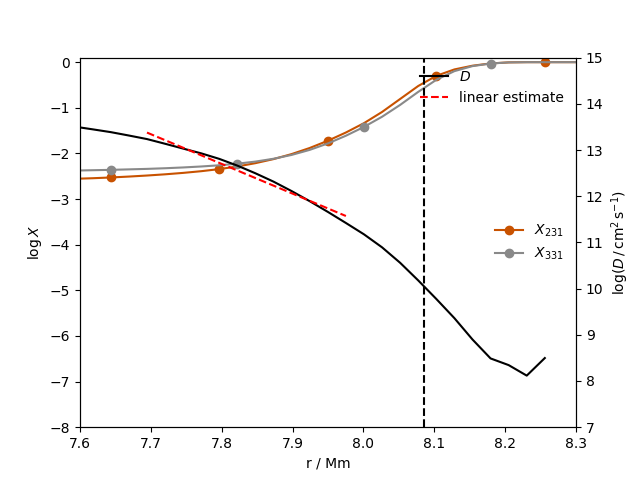

(7, 15)

In [5]:
D1.Dinv(231, 331, plot_Dlt0=False, approx_D = True, linelims = [7.7,8.0], linelabel = 'linear estimate')
pl.xlim(7.6,8.3)
pl.ylim(7,15)